## Outline

1. Loading datasets - Transforming images
2. VGG-16 with modification to network head
3. Using pre-trained models
4. Storing intermediate models
5. Resnet
6. Inception v3
7. Exercises

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")
print(device)

cuda:0


## Dataset, transforms, and visualisation

In [3]:
# We can load the training the test and train differently as we might want to do some tranformations or augmentations to the data, but in this example we are not doing that particularly.
# So basically here we have created two different objects for train and test.
transforms_train = transforms.Compose([
    # We are resizing the image as the vgg template that we are using call for it.
    # We have cropped the image from different locations so as to preserve the aspect ratio.
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    # Here we are normalising the RGB channels by giving them a mean and standard deviation of 0.5. We do this because the different color can have very different variation in a histogram
    # and the neural network will have to store it, but here we have preprocessed it so that the network does not have to compansate.
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize((mean for 3 channels), (std. for 3 channels))
    ])

transforms_test = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5) )
    ])

In [4]:
# Downloading the dataset and storing it locally, and then transforming the images using the transformers that we made earlier.
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True,
                                        transform=transforms_train)                                         

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True,
                                        transform=transforms_test)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Number of classes
num_classes = 10

In [6]:
batch_size = 4

In [7]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [8]:
# Instanciating a iterator for this train loader
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)

print(images[1].shape)
print(labels[1].item())
# The output has 4 images in a batch, contains 3 channels in a batch & it contains x and y dimentions of the images.

torch.Size([4, 3, 224, 224])
torch.Size([3, 224, 224])
6


In [9]:
# To plot the image we have to do one modification  - we will have to convert the image into numpy and then un-normalise it.

def imshow(img, title):
  npimg = img.numpy() / 2 + 0.5    # De-normalization is performed (/2 is to remove standard deviation - as it is equvalent to dividing by .5) (+0.5 is adding the mean)
  # the width of the image is batch size - 4 for out case
  plt.figure(figsize=(batch_size, 1))
  plt.axis('off')
  # This is to transpose the image so that the image axis comes first then the channels come - at the very end
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.title(title)
  plt.show()

In [10]:
def show_batch_images(dataloader):
  images, labels = next(iter(dataloader))
  # puts together the images to show together
  img = torchvision.utils.make_grid(images)
  # Here we are usiing the titles as the lables of all the images
  imshow(img, title=[str(x.item()) for x in labels])

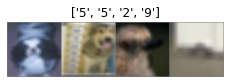

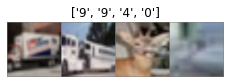

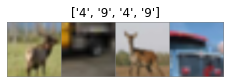

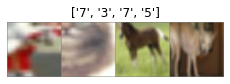

In [11]:
for i in range(4):
  show_batch_images(trainloader)

## Creating VGG-16

[VGGNet Model](https://pytorch.org/docs/master/_modules/torchvision/models/vgg.html)

In [12]:
# For the very popular network the torchvision officially supports the definations of the model architectures.
from torchvision import models

In [13]:
# Here bn stands for batch normalisation
vgg = models.vgg16_bn()

In [14]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [15]:
print(vgg.features[0])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [16]:
print(vgg.classifier[6])

Linear(in_features=4096, out_features=1000, bias=True)


In [17]:
# In CIFAR 10 there are only 10 classes but as we can see that the last layer of vgg classifier has 1000 we have to change that
final_in_features = vgg.classifier[6].in_features
# We are makeing a modified classifier by dropping the last one which has the wrong weights. Then adding it seperately
mod_classifier = list(vgg.classifier.children())[:-1]
mod_classifier.extend([nn.Linear(final_in_features, num_classes)])
print(mod_classifier)

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=10, bias=True)]


In [18]:
# Then finally we will change the modified classifier to the vgg network -> with 10 out features
vgg.classifier = nn.Sequential(*mod_classifier)
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

## Train CIFAR10

In [19]:
# We are taking 16 as batch size as it allows us to have a good amount of images to make small steps in gradients so that a single photo cannot persuade the whole operation.
# We are not taking it bigger than that as we have to store all the weights and biases on the gpu, and vgg in itself is a big netowrk so we might get "out of memory on gpu"
batch_size = 16

# Modifying the train and testloaders with the new batch size.
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [20]:
def evaluation(dataloader, model):
  total, correct = 0, 0
  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, pred = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (pred == labels).sum().item()
  return 100 * correct / total

In [21]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.05)

RuntimeError: No CUDA GPUs are available

In [51]:
loss_epoch_arr = []
max_epochs = 1

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):
  
  for i, data in enumerate(trainloader, 0):
    
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    
    opt.zero_grad()
    
    outputs = vgg(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    opt.step()
    
    del inputs, labels, outputs
    torch.cuda.empty_cache()
    
    if i % 100 == 0:
      print(f"Iteration: {i}/{n_iters}, Loss:{loss.item():0.2f}")
      print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
      
  loss_epoch_arr.append(loss.item())
  
  print(f"----------------------------------\nEpoch: {epoch}/{max_epochs}\nTest acc: {evaluation(testloader, vgg):0.2f}\nTrain acc: {evaluation(trainloader, vgg):0.2f}\n----------------------------------")
  

plt.plot(loss_epoch_arr)
plt.show()

Iteration: 0/3125.0, Loss:2.68
Iteration: 0/3125, Loss: 2.68


KeyboardInterrupt: ignored

### Freeze layers of Convolutional Operations

In [ ]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testlaoder = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [ ]:
vgg = models.vgg16_bn(pretrained=True)

In [ ]:
for param in vgg.parameters():
  param.requires_grad = False  # This ensures that the pretrained weights do not get updated during backpropagation

In [ ]:
final_in_features = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(final_in_features, num_classes)  # Here, we add our own final classification layer with trainable weights.

In [56]:
for param in vgg.parameters():
    if param.requires_grad:
        print(param.shape) # Here we see two tensors corresponding to the weights (4096x10) and bias (10) terms

torch.Size([10, 4096])
torch.Size([10])


In [ ]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.05)

In [58]:
loss_epoch_arr = []
max_epochs = 1

n_iter = np.ceil(50000/batch_size)

for epoch in range(max_epochs):
  
  for i, data in enumerate(trainloader, 0):
    
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    
    opt.zero_grad()
    
    outputs = vgg(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    opt.step()
    
    if i % 100 == 0:
      print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
      
    del inputs, labels, outputs
    torch.cuda.empty_cache()
    
  loss_epoch_arr.append(loss.item())
  
  print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, evaluation(testloader, vgg), evaluation(trainloader, vgg)))
  
plt.plot(loss_epoch_arr)
plt.show()

Iteration: 0/3125, Loss: 2.35
Iteration: 100/3125, Loss: 1.75
Iteration: 200/3125, Loss: 1.65
Iteration: 300/3125, Loss: 1.15


KeyboardInterrupt: ignored

### With model copies

In [ ]:
import copy

In [60]:
loss_epoch_arr = []
max_epochs = 1

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):
  
  for i, data in enumerate(trainloader, 0):
    
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    
    opt.zero_grad()
    
    outputs = vgg(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    opt.step()
    
    if min_loss > loss.item():
      min_loss = loss.item()
      best_model = copy.deepcopy(vgg.state_dict())
      print('Min loss %0.2f' % min_loss)
      
    if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
    del inputs, labels, outputs
    torch.cuda.empty_cache()
    
  loss_epoch_arr.append(loss.item())

Min loss 1.59
Iteration: 0/3125, Loss: 1.59
Min loss 1.55
Min loss 1.42
Min loss 0.97
Min loss 0.90
Min loss 0.71
Iteration: 100/3125, Loss: 1.65
Iteration: 200/3125, Loss: 1.86
Iteration: 300/3125, Loss: 2.45
Iteration: 400/3125, Loss: 1.98
Iteration: 500/3125, Loss: 2.23
Min loss 0.37
Iteration: 600/3125, Loss: 1.27
Iteration: 700/3125, Loss: 1.75
Iteration: 800/3125, Loss: 1.04
Iteration: 900/3125, Loss: 1.39
Iteration: 1000/3125, Loss: 2.69
Iteration: 1100/3125, Loss: 1.47
Iteration: 1200/3125, Loss: 2.17
Iteration: 1300/3125, Loss: 2.31
Iteration: 1400/3125, Loss: 2.08
Iteration: 1500/3125, Loss: 1.08
Iteration: 1600/3125, Loss: 2.37
Iteration: 1700/3125, Loss: 1.69
Iteration: 1800/3125, Loss: 1.52
Iteration: 1900/3125, Loss: 2.23
Iteration: 2000/3125, Loss: 3.06
Iteration: 2100/3125, Loss: 2.70
Iteration: 2200/3125, Loss: 3.74
Iteration: 2300/3125, Loss: 2.54
Iteration: 2400/3125, Loss: 2.59
Iteration: 2500/3125, Loss: 2.38
Iteration: 2600/3125, Loss: 1.86
Iteration: 2700/3125, L

In [61]:
vgg.load_state_dict(best_model)
print(evaluation(trainloader, vgg), evaluation(testloader, vgg))

46.102 45.84


## ResNet Model

[ResNet Model](https://pytorch.org/docs/master/_modules/torchvision/models/resnet.html)

In [62]:
resnet = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:02<00:00, 18261587.72it/s]


In [63]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [ ]:
for param in resnet.parameters():
    param.requires_grad = False

In [ ]:
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, num_classes)

In [66]:
for param in resnet.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 512])
torch.Size([10])


In [ ]:
resnet = resnet.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(resnet.parameters(), lr=0.01)

Min loss 2.46
Iteration: 0/3125, Loss: 2.46
Min loss 2.20
Min loss 2.19
Min loss 2.11
Min loss 2.04
Min loss 1.98
Min loss 1.77
Min loss 1.74
Min loss 1.56
Min loss 1.53
Iteration: 100/3125, Loss: 1.99
Min loss 1.46
Min loss 1.36
Iteration: 200/3125, Loss: 1.74
Min loss 1.23
Min loss 1.18
Min loss 1.15
Min loss 1.13
Iteration: 300/3125, Loss: 1.80
Min loss 1.10
Min loss 1.05
Iteration: 400/3125, Loss: 1.29
Min loss 0.99
Iteration: 500/3125, Loss: 1.06
Min loss 0.93
Iteration: 600/3125, Loss: 1.57
Min loss 0.91
Iteration: 700/3125, Loss: 1.43
Min loss 0.81
Min loss 0.76
Iteration: 800/3125, Loss: 1.39
Iteration: 900/3125, Loss: 1.29
Min loss 0.72
Iteration: 1000/3125, Loss: 1.55
Min loss 0.67
Iteration: 1100/3125, Loss: 1.52
Iteration: 1200/3125, Loss: 1.69
Iteration: 1300/3125, Loss: 1.05
Min loss 0.59
Iteration: 1400/3125, Loss: 1.48
Iteration: 1500/3125, Loss: 1.15
Iteration: 1600/3125, Loss: 1.50
Iteration: 1700/3125, Loss: 1.36
Iteration: 1800/3125, Loss: 1.46
Min loss 0.52
Iterati

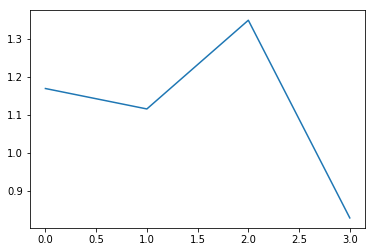

In [68]:
loss_epoch_arr = []
max_epochs = 4

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = resnet(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(resnet.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(testloader, resnet), evaluation(trainloader, resnet)))
    
    
plt.plot(loss_epoch_arr)
plt.show()

In [69]:
resnet.load_state_dict(best_model)
print(evaluation(trainloader, resnet), evaluation(testloader, resnet))

57.218 55.84


## Inception Model

[Inception Model](https://pytorch.org/docs/master/_modules/torchvision/models/inception.html)



![alt text](https://cloud.google.com/tpu/docs/images/inceptionv3onc--oview.png)

In [70]:
inception = models.inception_v3(pretrained=True)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth
100%|██████████| 108857766/108857766 [00:04<00:00, 24079556.67it/s]


In [71]:
print(inception)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [ ]:
for param in inception.parameters():
    param.requires_grad = False

In [ ]:
aux_in_features = inception.AuxLogits.fc.in_features
inception.AuxLogits.fc = nn.Linear(aux_in_features, num_classes)

In [74]:
for param in inception.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 768])
torch.Size([10])


In [ ]:
in_features = inception.fc.in_features
inception.fc = nn.Linear(in_features, num_classes)

In [76]:
for param in inception.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 768])
torch.Size([10])
torch.Size([10, 2048])
torch.Size([10])


In [ ]:
# Changing the input size to 299x299x3
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(299), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

transform_test = transforms.Compose([
    transforms.RandomResizedCrop(299), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

In [78]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, 
                                        transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                        download=True, 
                                        transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
batch_size=16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [ ]:
inception = inception.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(inception.parameters(), lr=0.01)

In [ ]:
def evaluation_inception(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs, aux_outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

Min loss 3.04
Iteration: 0/3125, Loss: 3.04
Min loss 2.98
Min loss 2.93
Min loss 2.86
Min loss 2.81
Min loss 2.72
Min loss 2.69
Min loss 2.67
Min loss 2.54
Iteration: 100/3125, Loss: 2.63
Min loss 2.53
Min loss 2.51
Min loss 2.50
Min loss 2.46
Min loss 2.38
Min loss 2.35
Min loss 2.34
Min loss 2.21
Iteration: 200/3125, Loss: 2.56
Min loss 2.20
Min loss 2.15
Min loss 2.08
Iteration: 300/3125, Loss: 2.69
Min loss 2.07
Min loss 2.04
Min loss 2.01
Min loss 1.92
Min loss 1.85
Min loss 1.81
Iteration: 400/3125, Loss: 2.42
Min loss 1.79
Min loss 1.77
Iteration: 500/3125, Loss: 2.19
Min loss 1.69
Iteration: 600/3125, Loss: 2.27
Min loss 1.65
Min loss 1.47
Iteration: 700/3125, Loss: 2.08
Iteration: 800/3125, Loss: 2.08
Min loss 1.36
Iteration: 900/3125, Loss: 2.08
Iteration: 1000/3125, Loss: 2.14
Iteration: 1100/3125, Loss: 1.95
Iteration: 1200/3125, Loss: 2.32
Iteration: 1300/3125, Loss: 2.45
Min loss 1.34
Iteration: 1400/3125, Loss: 2.26
Min loss 1.10
Iteration: 1500/3125, Loss: 2.63
Iteratio

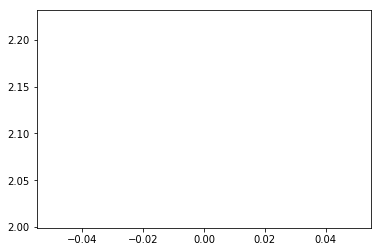

In [82]:
loss_epoch_arr = []
max_epochs = 1

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs, aux_outputs = inception(inputs)
        loss = loss_fn(outputs, labels) + 0.3 * loss_fn(aux_outputs, labels)  # Auxiliary loss function is given a weight of 0.3, as it is less crucial than the main loss

        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(inception.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation_inception(testloader, inception), 
        evaluation_inception(trainloader, inception)))
    
        """
        Loss of a completely random classifier would be calculated as ln(output_classes)
        In this case, since we have two loss functions weighted 1 and 0.3 with 10 output classes, random classifier loss would be around 1.3ln(10)
        """
    
    
plt.plot(loss_epoch_arr)
plt.show()

In [83]:
inception.load_state_dict(best_model)
print(evaluation_inception(trainloader, inception), evaluation_inception(testloader, inception))

47.142 47.39


## Exercises

1. Structure the above code into a series of functions and then call each model

2. Try out different hyperparameter combinations and try to achieve published results on different networks

3. Try out the CIFAR100 and STL10 datasets

4. Try out another model - SqueezeNet

5. Try training multiple layers and not just the last one